Pokemon Classification model using Kaggle Dataset, which contains 150 different pokemon classes. I’ll be using a pre-trained ResNet-34 to train the model. I was able to achieve 95% accuracy with just 5 epochs. Detailed explanation of steps can be found in my article [here](https://medium.com/@rjrjrjrj1996/pokemon-classifier-with-pytorch-656ed7fcc7bb)

In [2]:
#!pip install jovian

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import time
import PIL.Image as Image
from IPython.display import display

**Check if GPU is available**

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


We have GPU available.

**Quick look at the classes**

In [5]:
root_path = '/kaggle/input/pokemonclassification/PokemonData'
classes = sorted(os.listdir(root_path))
print(len(classes),classes)

150 ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking',

**Visualizing the data and check for balance/imbalance**

Total number of pokemons: 150
Total number of images: 6837


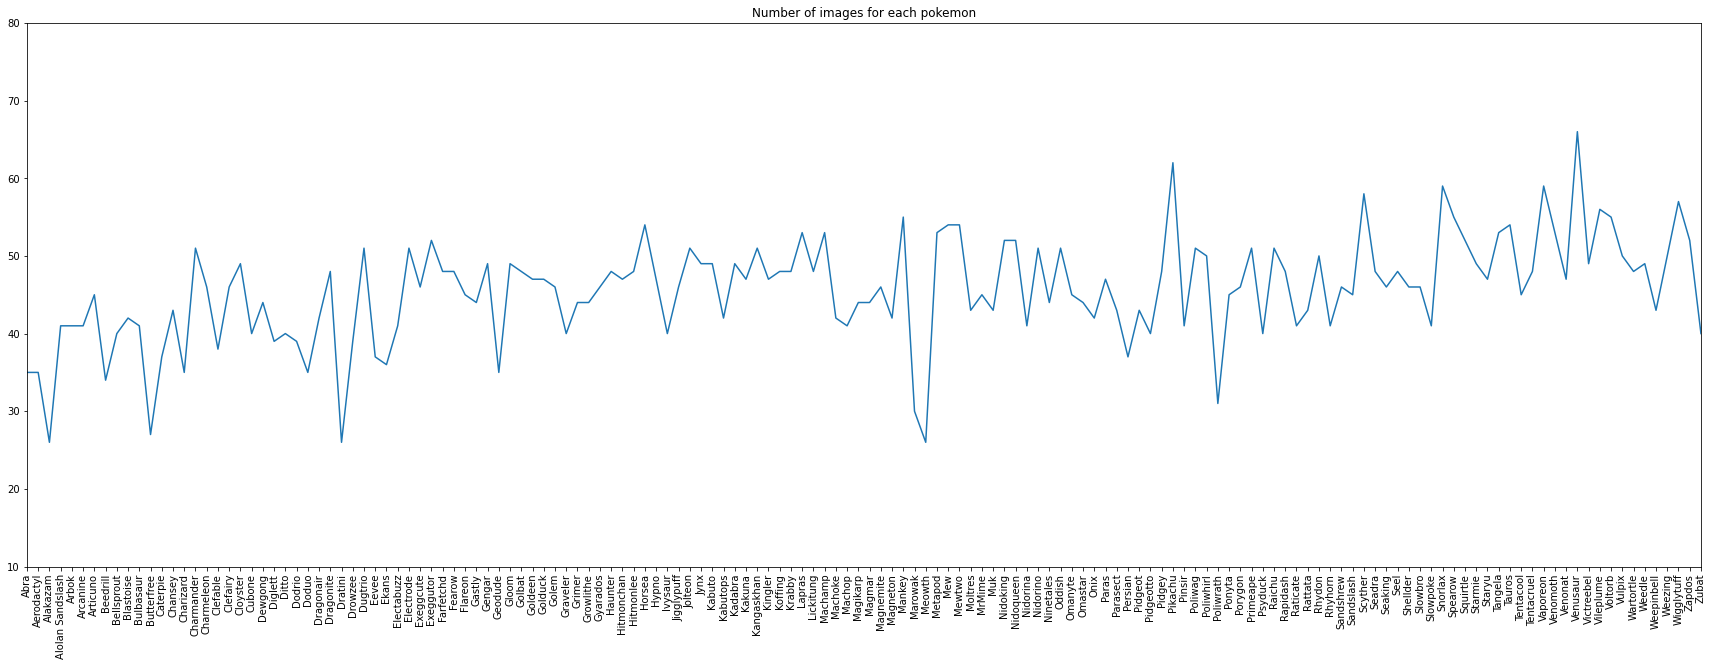

In [6]:
count=0
count_dict = {}
print(f'Total number of pokemons: {len(classes)}')
for pokemon in classes:
    dir_path = os.path.join(root_path,pokemon)
    count+=len(os.listdir(dir_path))
    count_dict[pokemon] = len(os.listdir(dir_path))
print(f'Total number of images: {count}')
fig = plt.figure(figsize = (30, 10))
sns.lineplot(x = list(count_dict.keys()), y = list(count_dict.values())).set_title('Number of images for each pokemon')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.ylim(10,80)
plt.show()

Number of images in each class not vary much. Therefore we conclude data is fairly balanced

Number of pokemon images in each class

In [7]:
sorted_list =  sorted(count_dict.items(), key=lambda item: item[1], reverse=True)
sorted_list

[('Venusaur', 66),
 ('Pikachu', 62),
 ('Snorlax', 59),
 ('Vaporeon', 59),
 ('Scyther', 58),
 ('Wigglytuff', 57),
 ('Vileplume', 56),
 ('Mankey', 55),
 ('Spearow', 55),
 ('Voltorb', 55),
 ('Horsea', 54),
 ('Mew', 54),
 ('Mewtwo', 54),
 ('Tauros', 54),
 ('Lapras', 53),
 ('Machamp', 53),
 ('Metapod', 53),
 ('Tangela', 53),
 ('Venomoth', 53),
 ('Exeggutor', 52),
 ('Nidoking', 52),
 ('Nidoqueen', 52),
 ('Squirtle', 52),
 ('Zapdos', 52),
 ('Charmander', 51),
 ('Dugtrio', 51),
 ('Electrode', 51),
 ('Jolteon', 51),
 ('Kangaskhan', 51),
 ('Nidorino', 51),
 ('Oddish', 51),
 ('Poliwag', 51),
 ('Primeape', 51),
 ('Raichu', 51),
 ('Poliwhirl', 50),
 ('Rhydon', 50),
 ('Vulpix', 50),
 ('Weezing', 50),
 ('Cloyster', 49),
 ('Gengar', 49),
 ('Gloom', 49),
 ('Jynx', 49),
 ('Kabuto', 49),
 ('Kadabra', 49),
 ('Starmie', 49),
 ('Victreebel', 49),
 ('Weedle', 49),
 ('Dragonite', 48),
 ('Farfetchd', 48),
 ('Fearow', 48),
 ('Golbat', 48),
 ('Haunter', 48),
 ('Hitmonlee', 48),
 ('Koffing', 48),
 ('Krabby', 48),

**Load the data and transform**

In [8]:
dataset_dir = root_path

tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
dataset = torchvision.datasets.ImageFolder(root=dataset_dir, transform = tfms)

Check one image to see how tranformations have been applied

torch.Size([3, 400, 400])
Label (numeric): 0
Label (textual): Abra


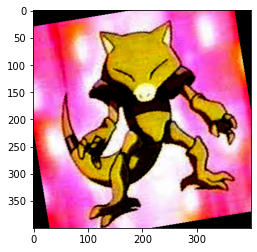

In [10]:
img, label = dataset[0]
print(img.shape)
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [11]:
torch.manual_seed(100)

**Spliting our data for training and testing, in the ratio 85% and 15% resp.**

In [12]:
train_size = int(len(dataset)*0.85)
val_size = int(len(dataset)*0.15) 

In [13]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(5797, 1023)

In [14]:
trainloader = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers = 2)
testloader = DataLoader(val_ds, batch_size = 32, shuffle=False, num_workers = 2)

Check images loaded in a single batch

images.shape: torch.Size([32, 3, 400, 400])


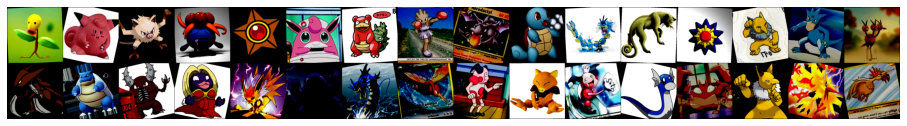

In [15]:
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# **Model training function**

Here we train our model, and after each epoch, we test the model on the test data to see how it's going

In [16]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

# Evaluate on training data

This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

In [18]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

Initialize the model. We are using pretrained ResNet-34

In [19]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 150) #No. of classes = 150
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [20]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=5)

Epoch 1, duration: 122 s, loss: 2.3871, acc: 50.2404
Accuracy of the network on the test images: 84 %
Epoch 2, duration: 113 s, loss: 0.3832, acc: 91.4835
Accuracy of the network on the test images: 91 %
Epoch 3, duration: 112 s, loss: 0.1773, acc: 96.0508
Accuracy of the network on the test images: 93 %
Epoch 4, duration: 111 s, loss: 0.0930, acc: 97.7335
Accuracy of the network on the test images: 94 %
Epoch 5, duration: 110 s, loss: 0.0586, acc: 98.3860
Accuracy of the network on the test images: 95 %
Finished Training


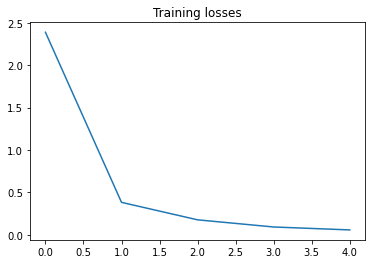

In [22]:
plt.title('Training losses')
plt.plot(training_losses)

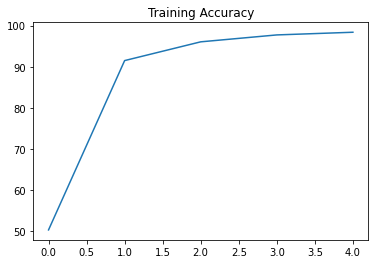

In [23]:
plt.title('Training Accuracy')
plt.plot(training_accs)

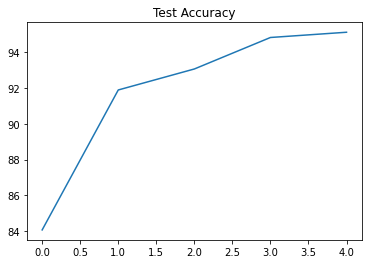

In [24]:
plt.title('Test Accuracy')
plt.plot(test_accs)

**Evaluate the model on never seen before images.**

In [27]:
# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

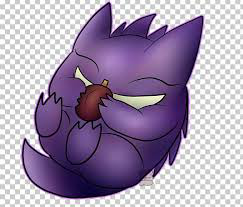

Gengar confidence:  8.912385940551758


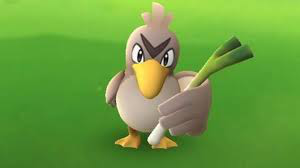

Farfetchd confidence:  12.277172088623047


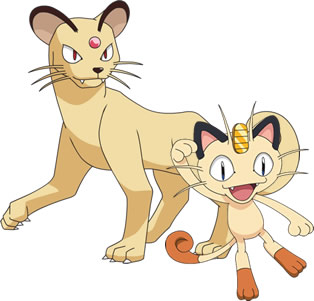

Persian confidence:  16.285001754760742


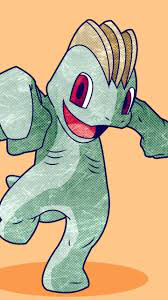

Machop confidence:  13.905016899108887


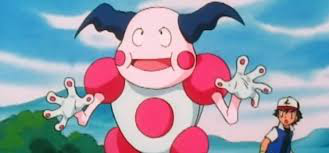

MrMime confidence:  14.511165618896484


In [30]:
test_imgs = ['1.jpg','2.jpg','3.jpg','4.jpg','6.jpg']

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for img in test_imgs:
    test_img_path = '../input/pokemontestfolder/'+ img
    image = Image.open(test_img_path)
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    image = image.cuda()
    output = model_ft(image)
    conf, predicted = torch.max(output.data, 1)

    display(Image.open(test_img_path))
    print(classes[predicted.item()], "confidence: ", conf.item())

In [31]:
!pip install jovian

     |████████████████████████████████| 63 kB 1.3 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=ff47cff4c7ae9481fbd0d65688cf47eaa014338f989e69ccaaaeeeb9c59e42d2
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [32]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project='pokemon-classification')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/gitrohitjain/pokemon-classification


<IPython.core.display.Javascript object>